# Conditioned Adversarial Generative Networks (cGANs)
---

We will create a *generative conditional network* from which we can obtain images for each of the classes in the dataset. Once we have trained it, we visualize the generation of 3 images of the FROG class (🐸) and 3 images of the HORSE class (🐎). **Given the complexity of the dataset and the low resolution of the images, it is normal to expect images where the generated object is not clearly identified.**

<br>
<img src='https://miro.medium.com/max/424/1*0hHJfc0V_Km_AgKkP892fw.png'>
<br>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# We load the CIFAR10 dataset into a variable.
(X_train, Y_train), (X_test, Y_test) = load_data()

# We One-Hot encode the output.
Y_train = to_categorical(Y_train)
Y_test  = to_categorical(Y_test)

#train_gen = ImageDataGenerator(rescale=1/255).flow(X_train, Y_train)
train_gen = ImageDataGenerator(rescale=1/255).flow(X_train.reshape(-1, 32, 32, 3), Y_train)

170498071/170498071 [==============================] - 2s 0us/step


In [2]:
# Name of the classes ordered by the corresponding index.
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

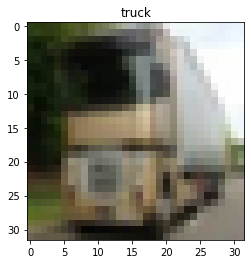

In [3]:
# We select a random index.
idx = np.random.randint(0, 5000)

# We display one of the images.
plt.imshow(X_train[idx])
plt.title(class_names[np.argmax(Y_train[idx])])
plt.show()

In [4]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

latent_dim  = 128
image_size  = 32
num_classes = 10 

def get_discriminator():
  # Create the model discriminator.
  discriminator = Sequential(name="discriminator")

  # 💡 >>> Now the discriminator input will increment the number
   # >>> of feeds to add the One-hot vector
  discriminator.add(Input(shape=(32, 32, 3 + num_classes)))
  
  discriminator.add(Conv2D(64, kernel_size=4, strides=2, padding="same"))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(alpha=0.2))
  
  discriminator.add(Conv2D(128, kernel_size=4))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(alpha=0.2))

  discriminator.add(Conv2D(128, kernel_size=4))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(alpha=0.2))

  discriminator.add(GlobalMaxPooling2D())
  discriminator.add(Dense(1, activation="sigmoid"))

  discriminator.summary()
  return discriminator

get_discriminator()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        13376     
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       131200    
                                                                 
 batch_normalization_1 (Batc  (None, 13, 13, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 13, 13, 128)     

In [5]:
def get_generator(latent_dim=128):

  generator = Sequential(name="generator")
  
  # 💡 >>> Now the input receives the latent vector and the
  # concatenated One-hot vector.
  generator.add(Input(shape=(latent_dim + num_classes)))
  
  generator.add(Dense(3 * 3 * latent_dim))
  generator.add(Reshape((3, 3, latent_dim)))

  generator.add(Conv2DTranspose(128, kernel_size=4, strides=2))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU(alpha=0.2))

  generator.add(Conv2DTranspose(256, kernel_size=4, strides=2))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU(alpha=0.2))
  
  generator.add(Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU(alpha=0.2))
  
  generator.add(Conv2D(3, kernel_size=5, strides=1, padding="valid", activation="sigmoid"))

  generator.summary()
  return generator

get_generator()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1152)              160128    
                                                                 
 reshape (Reshape)           (None, 3, 3, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        262272    
 nspose)                                                         
                                                                 
 batch_normalization_3 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 18, 18, 256)      52

In [6]:
class GAN(tf.keras.Model):

  def __init__(self, discriminator, generator, latent_dim):
      super(GAN, self).__init__()
      # We save the discriminator and the generator.
      self.discriminator = discriminator
      self.generator     = generator
      self.latent_dim    = latent_dim

  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super(GAN, self).compile(d_optimizer, g_optimizer, loss_fn)
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn
  
  def train_step(self, data):

    # 💡 >>> Now the data is the input and the labels.
    real_images, one_hot_labels = data

    # 💡 >>> We format the One-hot vector to image size.
    image_one_hot_labels = one_hot_labels[:, :, None, None]
    image_one_hot_labels = tf.repeat(image_one_hot_labels, repeats=[image_size * image_size])
    image_one_hot_labels = tf.reshape(image_one_hot_labels, (-1, image_size, image_size, num_classes))

    # ----------- DETECTOR TRAINING ------------- #

    # Lot Size
    batch_size = tf.shape(real_images)[0]

    # We generate random vectors as input to the generating network.
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

     # 💡 >>> We add the class info to the input vectors of the generator.
    random_latent_vectors = tf.concat([random_latent_vectors, one_hot_labels], axis=1)

    # We use the vectors to generate random images. (We decode)
    fake_images = self.generator(random_latent_vectors)

    # 💡 >>> We add the class info to the decoder input images.
    fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
    real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)

    # We concatenate them to the set of real images.
    combined_images = tf.concat([fake_image_and_labels, real_image_and_labels], axis=0)

    # We generate the output for each image (Fake: 1 / Real: 0)
    labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

    # Add random noise to the labels - important trick!
    labels += 0.05 * tf.random.uniform(tf.shape(labels))

    with tf.GradientTape() as tape:

      # Predictions made by the discriminator.
      predictions = self.discriminator(combined_images)

      # We evaluate the results of the discriminator with the cost function.
      d_loss = self.loss_fn(labels, predictions)

    # Calculate the gradient with the discriminator error.
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)

    # Update the parameters with the gradients.
    self.d_optimizer.apply_gradients(
          zip(grads, self.discriminator.trainable_weights)
    )

    # ----------- GENERATOR TRAINING ------------- #

    # We create new vectors to generate random images. (We decode)
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

    # We create the labels with which to supervise the training of the generator.
    misleading_labels = tf.zeros((batch_size, 1))

    # We train the generator WITHOUT updating the detector!
    with tf.GradientTape() as tape:

      # 💡 >>> We add the class info to the input vectors of the generator.
      random_latent_vectors = tf.concat([random_latent_vectors, one_hot_labels], axis=1)

      # 💡 >>> We generate and add the class info.
      fake_images = self.generator(random_latent_vectors)
      fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)

      # We obtain new predictions by passing to the discriminator what is generated.
      predictions = self.discriminator(fake_image_and_labels)

      # We calculate the error of the generator in its task of confusing the discriminator.
      g_loss = self.loss_fn(misleading_labels, predictions)

    # Calculate the gradient of the generator.
    grads = tape.gradient(g_loss, self.generator.trainable_weights)

    # Update the parameters with the gradients.
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

    return {}

In [7]:
from tensorflow.keras.callbacks import Callback

# 💡 >>> We create a personalized callback to visualize the evolution
# of the generator after each epoch.
class GANMonitor(Callback):

    def on_epoch_end(self, epoch, logs=None):

        for cls in [6, 7]:
          random_latent_vectors = tf.random.normal(shape=(3, self.model.latent_dim))
          # We always generate vectors of the number 3.
          one_hot_vectors = tf.reshape(tf.repeat(to_categorical(cls, num_classes=10)[None,:], repeats=3, axis=0), (3, num_classes))
          generated_image = self.model.generator(tf.concat([random_latent_vectors, one_hot_vectors], axis=1))


          fig, axs = plt.subplots(1, 3)

          for i in range(3):
            if generated_image.shape[3] > 1:
              fig.axes[i].imshow(generated_image[i,:,:,:])
              fig.axes[i].axis("off")
            else:
              fig.axes[i].matshow(generated_image[i,:,:,0])
              fig.axes[i].axis("off")

          plt.title("frog" if cls == 6 else "horse")
          plt.show()

In [8]:
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *

# We create a GAN with our class.
gan = GAN(discriminator=get_discriminator(), generator=get_generator(), latent_dim=latent_dim)

# We configure the optimizers of each part...
gan.compile(d_optimizer=Adam(learning_rate=0.0001),
            g_optimizer=Adam(learning_rate=0.0001),
            loss_fn=BinaryCrossentropy())

# ...and we give it to train.
#gan.fit(train_gen, epochs=1000, callbacks=[GANMonitor()])

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        13376     
                                                                 
 batch_normalization_6 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 128)       131200    
                                                                 
 batch_normalization_7 (Batc  (None, 13, 13, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 13, 13, 128)     

In [ ]:
gan.fit(train_gen, epochs=1000, callbacks=[GANMonitor()], steps_per_epoch=100)

Epoch 1/1000
